<h1 style="font-size:36px;">Convolutional Neural Network(CNN)</h1>

CNN architecture includes several convolutional layers followed by several fully connected layers. A matrix of Bitcoin price data over the time range is used as input. Convolutional layers create feature maps by acting on the input matrix of the filters. Fully connected layers flatten the feature maps and render them into the output layer. When this architecture is used for Bitcoin price prediction, it allows to learn visual features of historical price data and use these features to predict future prices.

CNN mimarisi, birkaç evrişimli katman ve ardından birkaç tam bağlantılı katman içerir. Girdi olarak, zaman aralığındaki Bitcoin fiyat verilerinin bir matrisi kullanılır. Evrişimli katmanlar, filtrelerin girdi matrisi üzerinde hareket ederek özellik haritalarını oluşturur. Tam bağlantılı katmanlar, özellik haritalarını düzleştirir ve çıktı katmanına doğru işler. Bu mimari, Bitcoin fiyat tahmini için kullanıldığında, geçmiş fiyat verilerinin görsel özelliklerini öğrenmeyi ve bu özelliklerin gelecekteki fiyatları tahmin etmek için kullanılmasını sağlar.

<h1 style="font-size:15px;">Summary of the Model</h1>

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 128)            1664      
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 64)             16448     
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                1650      
                                                      

Model 3 uses three Conv1D layers containing 128, 64 and 32 neurons and then reduces the size using a MaxPooling1D layer. It then creates an intermediate output using a Dense layer, and finally uses a Dense layer containing a single output neuron, the output layer. Model 3 has 23,941 trainable parameters.

Model 3, 128, 64 ve 32 adet nöron içeren üç adet Conv1D katmanı kullanır ve ardından bir MaxPooling1D katmanı kullanarak boyutu indirir. Daha sonra, bir Yoğun katmanı kullanarak bir ara çıktı oluşturur ve son olarak, çıkış katmanı olan tek bir çıktı nöronu içeren bir Yoğun katman kullanır. Model 3, 23,941 eğitilebilir parametreye sahiptir.

<h1 style="font-size:15px;">Model Outputs</h1>

In [97]:
print(CNN3_ERROR)

     MSE     RMSE      MAE       R2
0.002666 0.051633 0.036333 0.658287



<h3 style="font-size:24px;">Data preprocessing and Preparation</h3>

In [77]:
%matplotlib inline
!pip install statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from datetime import datetime, timedelta

from scipy import stats
import statsmodels.api as sm
from itertools import product

In [78]:
#importing the btc data
data=pd.read_csv('btcusd.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3145,2023-04-28,29481.013672,29572.791016,28929.609375,29340.261719,29340.261719,17544464887
3146,2023-04-29,29336.566406,29452.455078,29088.042969,29248.488281,29248.488281,10662634333
3147,2023-04-30,29245.515625,29952.029297,29114.021484,29268.806641,29268.806641,14652199272
3148,2023-05-01,29227.103516,29329.935547,27680.792969,28091.568359,28091.568359,18655599976


In [79]:
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')

In [80]:
aim = 'Close'

In [81]:
train_data = data.iloc[2512:]
test_data = data.iloc[:2512]

In [82]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [83]:
def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [84]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len = 5, zero_base = True, test_size = 0.2)

In [85]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 2, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu'))
model.add(Conv1D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'nadam', loss = 'mse')

In [86]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4, 128)            1664      
                                                                 
 conv1d_7 (Conv1D)           (None, 3, 64)             16448     
                                                                 
 conv1d_8 (Conv1D)           (None, 2, 32)             4128      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                1650      
                                                      

In [87]:
result = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 100, verbose=1, shuffle=True)

Epoch 1/100
20/20 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 9.5798e-04 - val_loss: 0.0019
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 9.1474e-04 - val_loss: 0.0019
E

20/20 [==============================] - 0s 4ms/step - loss: 1.5050e-04 - val_loss: 0.0026
Epoch 81/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3695e-04 - val_loss: 0.0025
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 1.6504e-04 - val_loss: 0.0026
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 1.7121e-04 - val_loss: 0.0025
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3458e-04 - val_loss: 0.0026
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 1.4913e-04 - val_loss: 0.0025
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 1.5633e-04 - val_loss: 0.0026
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3222e-04 - val_loss: 0.0026
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 1.3604e-04 - val_loss: 0.0027
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 1.2

<ipython-input-89-c4105b6aec7f>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(result.history['loss'],'r', linewidth = 2, label = 'Training loss', color = 'purple')
<ipython-input-89-c4105b6aec7f>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(result.history['val_loss'], 'g',linewidth=2, label = 'Validation loss', color = 'yellowgreen')


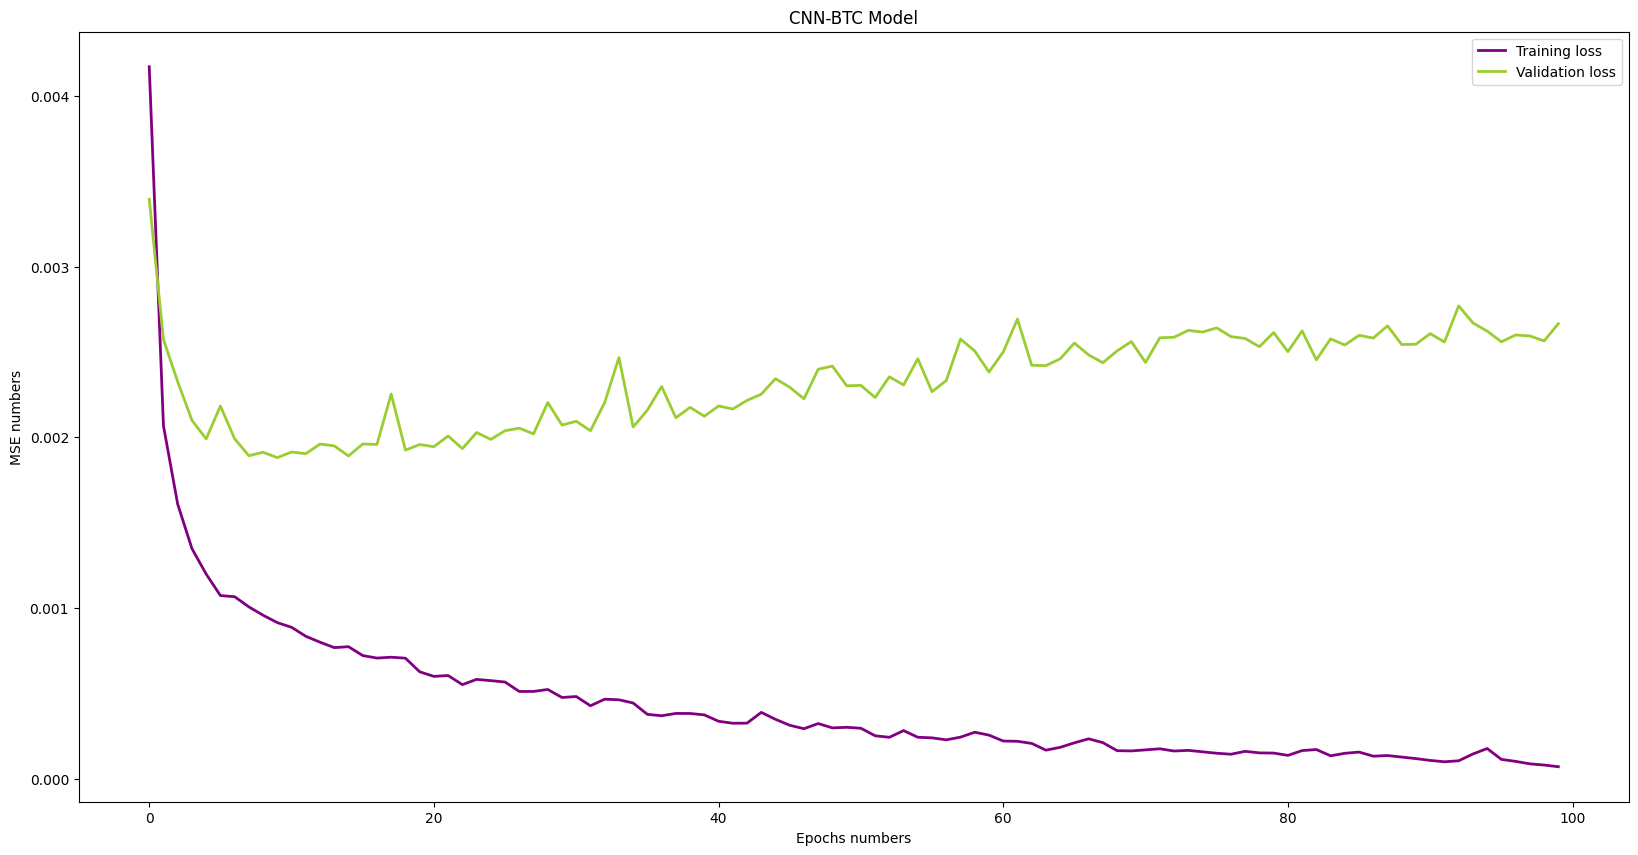

In [89]:
plt.figure(figsize=(20,10))
plt.plot(result.history['loss'],'r', linewidth = 2, label = 'Training loss', color = 'purple')
plt.plot(result.history['val_loss'], 'g',linewidth=2, label = 'Validation loss', color = 'yellowgreen')
plt.title('CNN-BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.legend()
plt.show()

In [90]:
targets = test_data[aim][5:]
preds = model.predict(X_test).squeeze()


79/79 [==============================] - 0s 591us/step


In [91]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
MSE = mean_squared_error(y_test, preds )
RMSE = np.sqrt(MSE)
MSE

0.002665976413387855

In [92]:
MAE= mean_absolute_error(preds, y_test)
R2= r2_score( y_test, preds)
R2

0.658286873077093

In [93]:
import pandas as pd

# Değerleri bir sözlük yapısında sakla
results = {'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]}

# DataFrame oluştur ve index değerlerini varsayılan değerlerle ata
CNN3_ERROR= pd.DataFrame.from_dict(results, orient='index').T

# DataFrame'i ERROR ismiyle kaydet
CNN3_ERROR = CNN3_ERROR.to_string(index=False)

# ERROR'u yazdır

print(CNN3_ERROR)

     MSE     RMSE      MAE       R2
0.002666 0.051633 0.036333 0.658287


In [94]:
preds = test_data[aim].values[:-5] * (preds + 1)
preds = pd.Series(index = targets.index, data = preds)

In [95]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.plot(line1, label=label1, linewidth=lw, color='purple')
    ax.plot(line2, label=label2, linewidth=lw, ls='--', color='yellowgreen')
    ax.set_ylabel('ETH Price in USD', fontsize=14)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='best', fontsize=12);

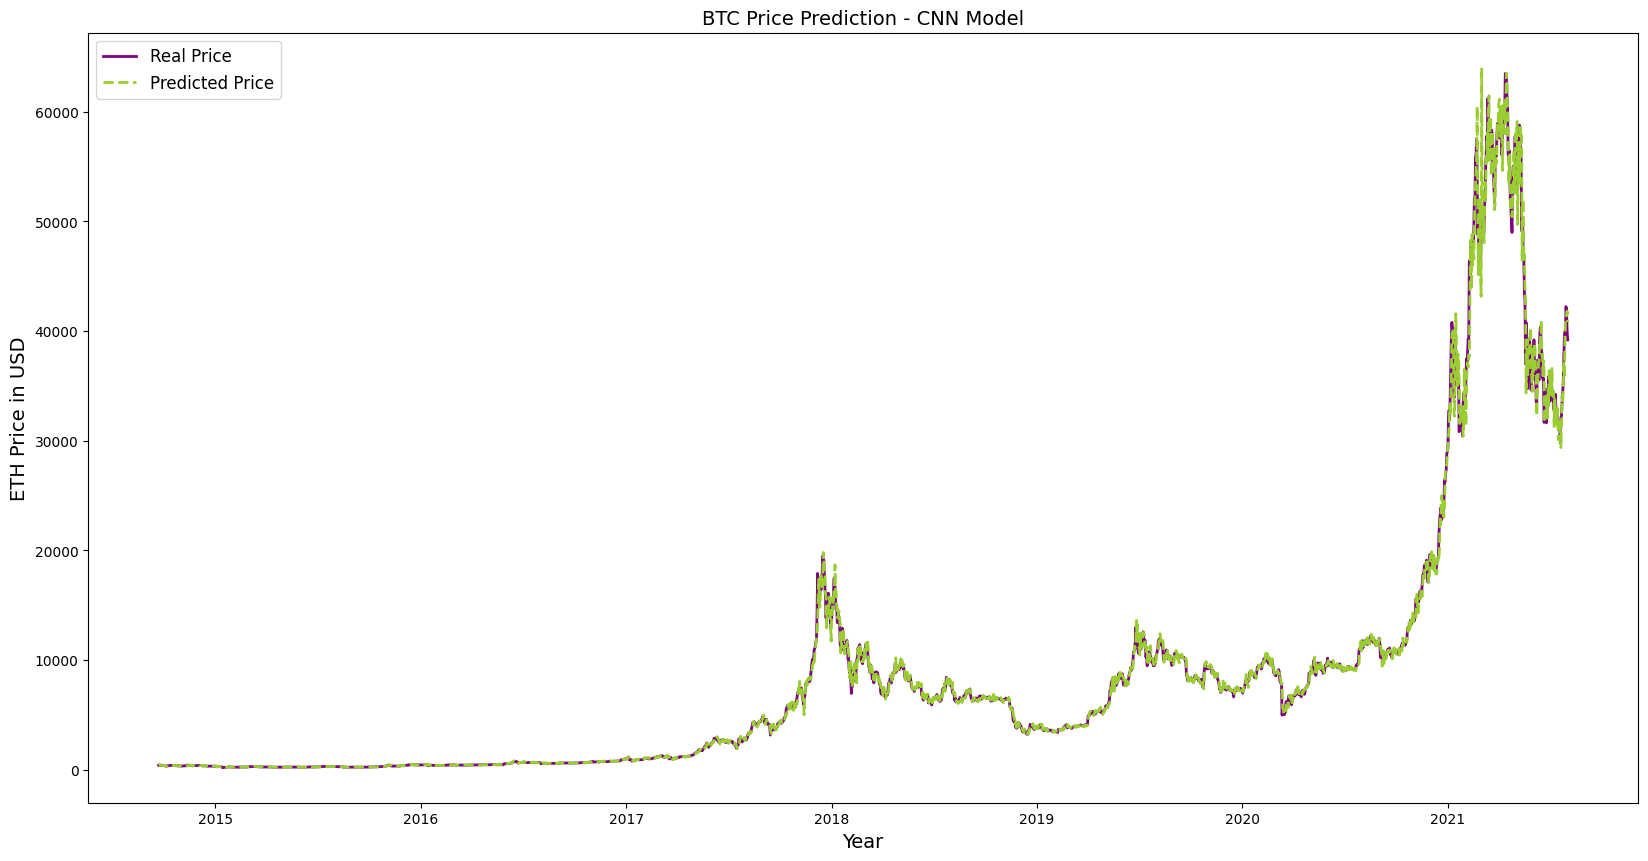

In [96]:
line_plot(targets, preds, 'Real Price', 'Predicted Price', title = 'BTC Price Prediction - CNN Model')